# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

# Solución

In [1]:
# Imports
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

from nltk.stem.porter import PorterStemmer

import sklearn.neural_network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


## Carga de datos

In [2]:
dataFrame = pd.read_csv(
  "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
  sep = ',',
  thousands = None,
  decimal = '.',
  encoding='latin-1'
)

dataFrame.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
dataFrame.describe()

,type,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


## Distribución de los datos

Gráfica que compara número de mensajes *ham* y *spam* que contiene el data set cargado.

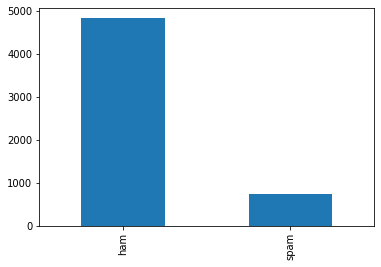

In [4]:
dataFrame.type.value_counts().plot.bar();

## Aplicación de Stemmer

In [5]:
stemmer = PorterStemmer()
dataFrame['stemmed'] = dataFrame.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))
dataFrame.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


## Acondicionamiento de los datos

Utilizamos *CountVectorizer* para representar los datos como *Bag-of-words*

In [6]:
count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(dataFrame.stemmed).toarray()

##
## Las filas contienen los mensajes
## y las clomunas los términos
##

dtm.shape

(5574, 1540)

## Modelo de regresión logística
Construcción del modelo de regresión logística validando su robustez con *CrossValidation* de 5 iteraciones

In [7]:
regresionLogistica = linear_model.LogisticRegression()

# Datos base
dEntrada = dtm[0:][:].copy()
dSalida = dataFrame[["type"]][:].copy()

# Nuestro set de datos de prueba siempre será de 100 elementos
tSetPrueba = 100

# Evaluaremos 5 corridas para el CrossValidation
corridas = 5

# Matriz de confusión acumulada
porcentaje = 0

for corrida in range(0, corridas):
  datosEntrenamientoEntrada = []
  datosEntrenamientoSalida = []
  datosPruebaEntrada = []
  datosPruebaSalida = []

  # Obtenemos el indice inicial para el set de pruebas aleatoriamente
  # Garantiza que todos los sets tengan 100 elementos
  i = random.randrange(0, len(dEntrada) - tSetPrueba)

  datosEntrenamientoEntrada.extend(dEntrada[:i])
  datosEntrenamientoEntrada.extend(dEntrada[(i + tSetPrueba):])

  datosEntrenamientoSalida = np.append(dSalida[:i], dSalida[(i + tSetPrueba):])

  datosPruebaEntrada.extend(dEntrada[i:i+tSetPrueba])
  datosPruebaSalida = dSalida[i:i+tSetPrueba]

  regresionLogistica.fit(datosEntrenamientoEntrada, datosEntrenamientoSalida)
  pronosticos = regresionLogistica.predict(np.array(datosPruebaEntrada))

  mConf = confusion_matrix(y_true = datosPruebaSalida.copy(), y_pred = pronosticos)
  porcentaje += (mConf[0][0] + mConf [1][1]) / mConf.sum()

print(porcentaje/corridas)

0.9720000000000001


Para el *CrossValidation* se están ejecutando 5 corridas las cuales calculan 5 sets aleatorios para entrenamiento y pruebas, con la caracteristica de que cada set de pruebas calculado tiene un tamaño de 100 elementos.

Como resultado del modelo de regresión logística, se obtiene que la exactitud promedio de las 5 corridas del *CrossValidation* es de 97.2% aproximadamnete.

## Red Neuronal
Costruccion de red neuronal:
*   Tasa de aprendizaje de 0.01
*   Máximas neuronas a evaluar 10
*   Función de activacion logistica




In [14]:
# Configuración red neuronal
maxNeuronas = 10
tasaApren = 0.01

# Datos base
dEntrada = dtm[0:][:].copy()
dSalida = dataFrame[["type"]][:].copy()

# Nuestro set de datos de prueba siempre será de 100 elementos
tSetPrueba = 100

# Evaluaremos 5 corridas
corridas = 5

# Matriz de confusión acumulada
mejorPorcentaje = 0
umbral = 0.05
canNeuMejorResultado = 0

for neuCapaOculta in range (1, maxNeuronas + 1):
  mlp = sklearn.neural_network.MLPClassifier(
                  hidden_layer_sizes = (neuCapaOculta,),  # Una capa oculta con una neurona
                  activation = 'logistic',                # {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
                  learning_rate_init = tasaApren,         # Valor de la tasa de aprendizaje
                  learning_rate = 'adaptive',             # La tasa no se adapta automáticamente          
                  shuffle = True,             
                  warm_start = True) 
  
  porcenRedNeuronal = 0
  mConfPorcentaje = 0
  for corrida in range (0, corridas):
    datosEntrenamientoEntrada = []
    datosEntrenamientoSalida = []
    datosPruebaEntrada = []
    datosPruebaSalida = []

    # Obtenemos el indice inicial para el set de pruebas aleatoriamente
    # Garantiza que todos los sets tengan 100 elementos
    i = random.randrange(0, len(dEntrada) - tSetPrueba)

    datosEntrenamientoEntrada.extend(dEntrada[:i])
    datosEntrenamientoEntrada.extend(dEntrada[(i + tSetPrueba):])

    datosEntrenamientoSalida = np.append(dSalida[:i], dSalida[(i + tSetPrueba):])

    datosPruebaEntrada.extend(dEntrada[i:i+tSetPrueba])
    datosPruebaSalida = dSalida[i:i+tSetPrueba]

    mlp.fit(datosEntrenamientoEntrada, datosEntrenamientoSalida)
    pronosticos = mlp.predict(np.array(datosPruebaEntrada))

    mConf = confusion_matrix(y_true = datosPruebaSalida.copy(), y_pred = pronosticos)
    mConfPorcentaje += (mConf[0][0] + mConf [1][1]) / mConf.sum()
  porcenRedNeuronal = mConfPorcentaje / corridas

  if (porcenRedNeuronal - mejorPorcentaje > umbral) :
    mejorPorcentaje = porcenRedNeuronal
    canNeuMejorResultado = neuCapaOculta

print("Porcentaje: " ,mejorPorcentaje)
print("Neuronas: " ,canNeuMejorResultado)

Porcentaje:  0.998
Neuronas:  1


Para el *CrossValidation* se están ejecutando 5 corridas las cuales calculan 5 sets aleatorios para entrenamiento y pruebas, con la caracteristica de que cada set de pruebas calculado tiene un tamaño de 100 elementos. Dicho cálculo se ejecuta por cada red neuronal y con base en el promedio de los resultados se compara con las demas redes neuronales para identificar la cantidad de neuronas óptimas en el modelo.

Luego de evaluar el modelo, obtenemos como mejor resultado una red neuronal con 1 neurona en la capa oculta y una exactitud de 99.8% aproximadamente.

# Conclusión

Comparando ambos modelos y aplicando técnicas como *CrossValidation* para evaluar la robuztes de los modelos, podemos sugerir que el modelo más exacto en promedio es la red neuronal con una neurona en la capa oculta la cual presenta mas de una unidad de mejora en la exactitud de los resultados.

*   Regresión logística : 97.2%
*   Red neuronal : 99.8%


